In [1]:
import os
print(os.listdir("dataset"))

['.DS_Store', 'Annotation', 'all-dogs']


In [2]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

There are 20579 pictures of dogs.


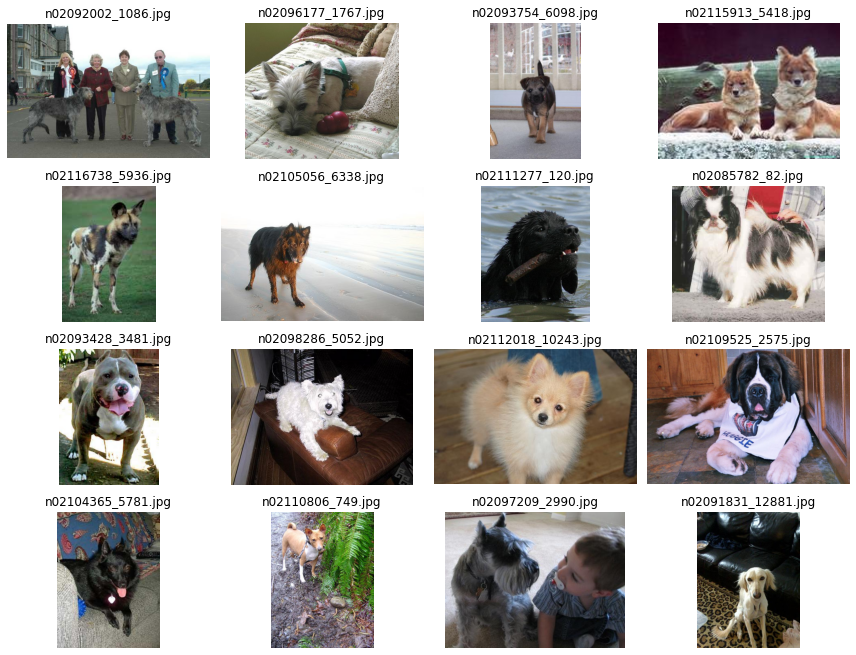

In [3]:
PATH = 'dataset/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [4]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('dataset', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


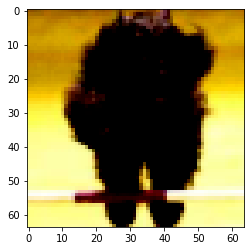

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


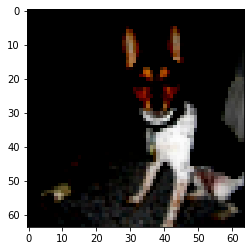

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


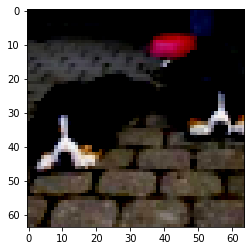

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


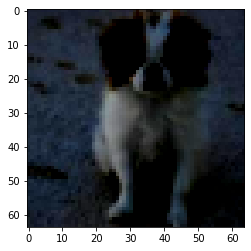

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


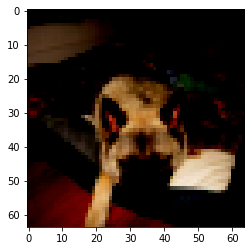

In [5]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self, n=128, channels=3):
        super(Generator, self).__init__()
        
        self.n = n
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.n, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.n, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

In [7]:
generator_lr = 0.001 
discriminator_lr = 0.0005 
batch_size = 32
real_label = 0.9
fake_label = 0
epochs = 100
n = 128
beta = 0.5

In [8]:
generator = Generator(n)
discriminator = Discriminator()
loss_gen = []
loss_des = []
epoch_time = []
loss = nn.BCELoss() 
optimizer_dis = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(beta, 0.999))
optimizer_gen = optim.Adam(generator.parameters(), lr=generator_lr, betas=(beta, 0.999))
fixed_noise = torch.randn(25, n, 1, 1)

In [9]:
def loss_graph(loss_gen, loss_des, epoch):
    plt.figure(figsize=(8,8))
    plt.title("Generator and Discriminator Loss for EPOCH "+ str(epoch))
    plt.plot(loss_gen,label="GENERATOR")
    plt.plot(loss_des,label="DISCRIMINATOR")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [10]:
def get_generated_image(num_image=4):
    images = []
    for _ in range(num_image):
        noise = torch.randn(1, n, 1, 1)
        image_gen = generator(noise).clone().detach().squeeze(0)
        image_gen = image_gen.numpy().transpose(1, 2, 0)
        images.append(image_gen)
    
    figure, ax = plt.subplots(1, len(images), figsize = (64,64))
    for index, axis in enumerate(ax):
        axis.axis('off')
        image_array = images[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

<ipython-input-11-9963e45327b0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for track, (actual_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.1914 Generator Loss: 1.5835
Descriminator Loss : 1.2774 Generator Loss: 2.0532


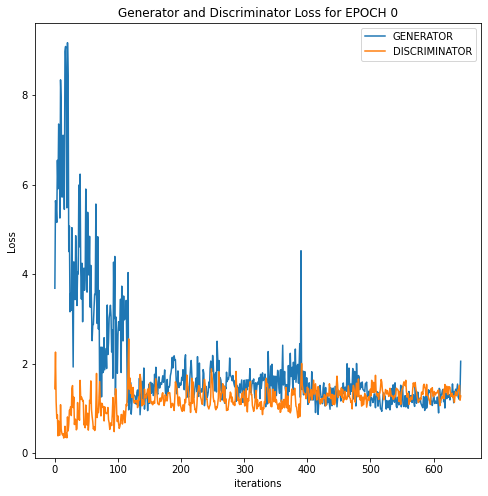

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


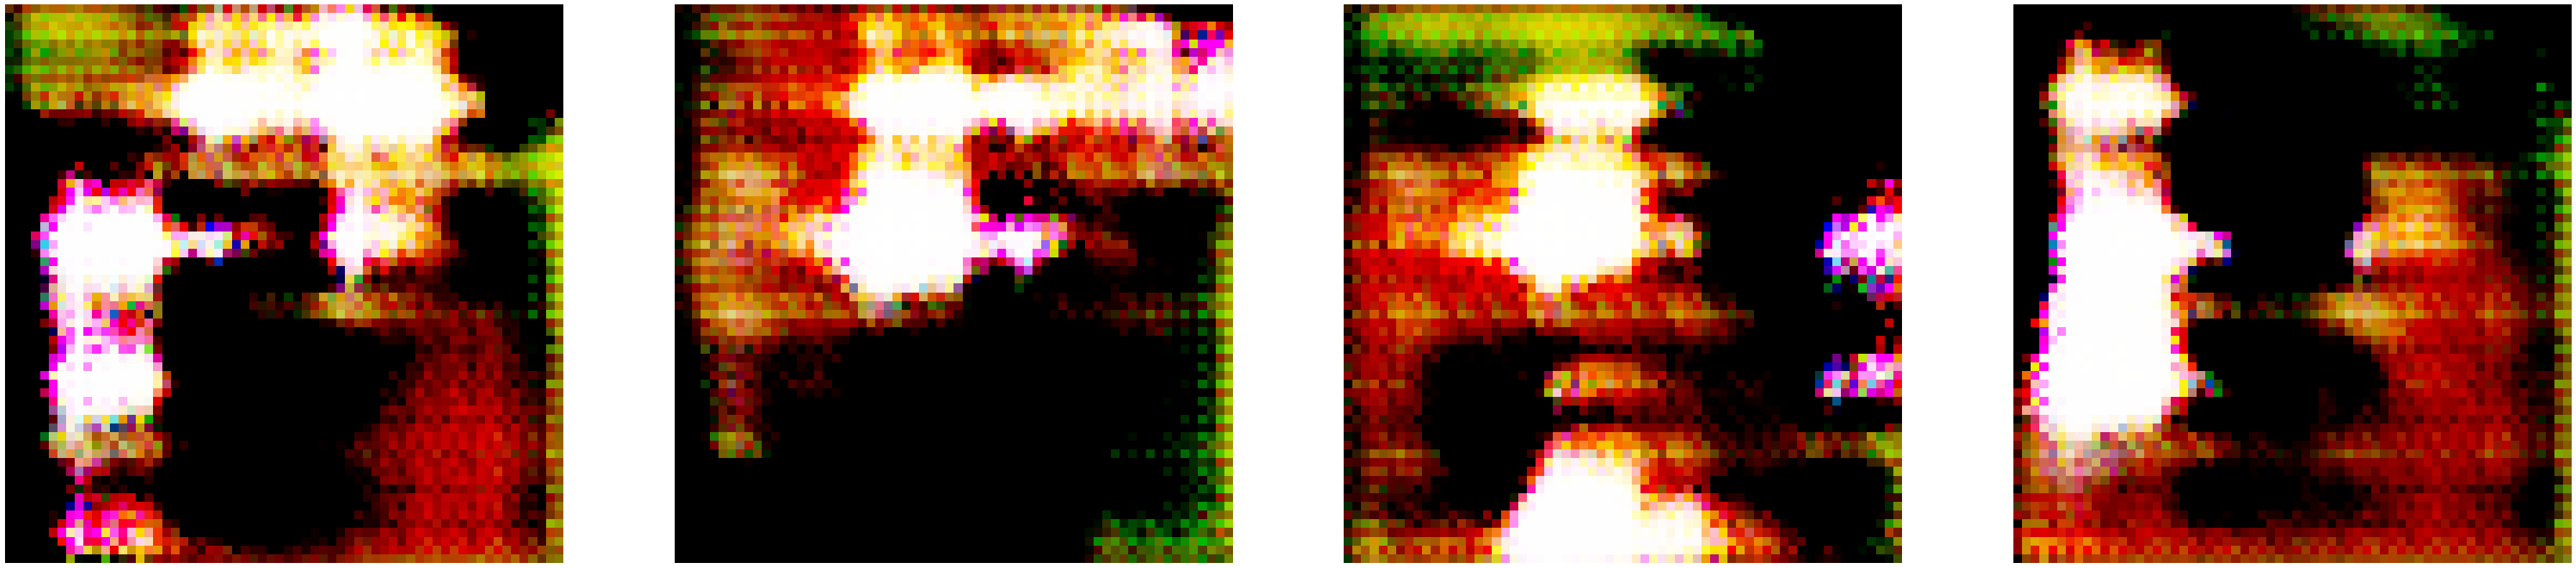

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.5098 Generator Loss: 0.9587
Descriminator Loss : 1.1055 Generator Loss: 2.0279


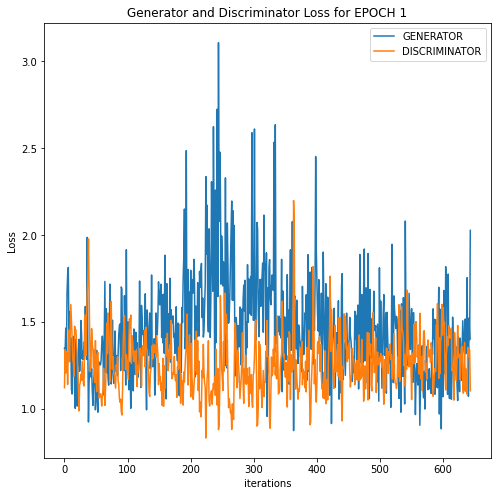

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.4559 Generator Loss: 1.0122
Descriminator Loss : 1.2612 Generator Loss: 1.4791


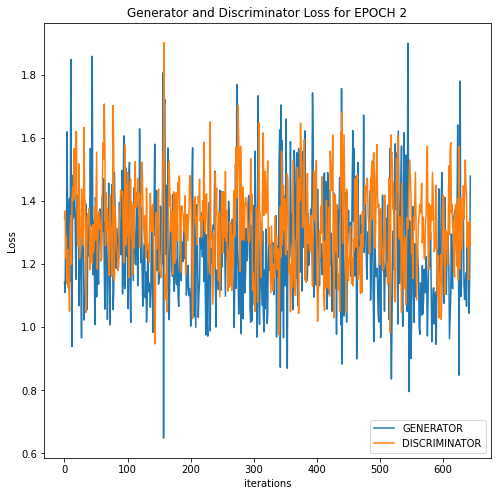

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2733 Generator Loss: 1.1804
Descriminator Loss : 1.6095 Generator Loss: 1.9685


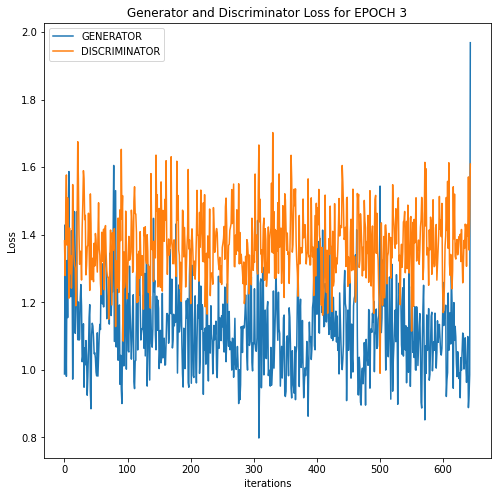

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2616 Generator Loss: 1.1945
Descriminator Loss : 1.2645 Generator Loss: 1.8144


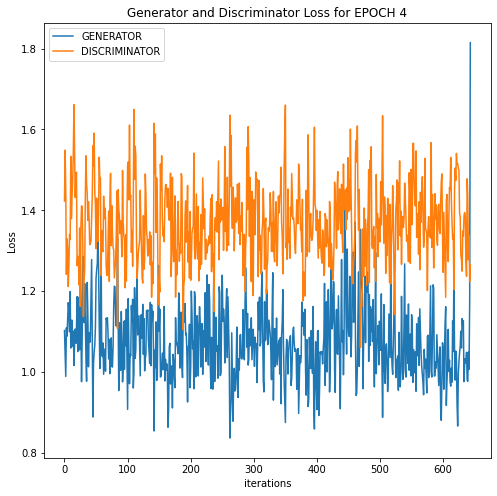

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.5187 Generator Loss: 0.9042
Descriminator Loss : 1.2723 Generator Loss: 1.8089


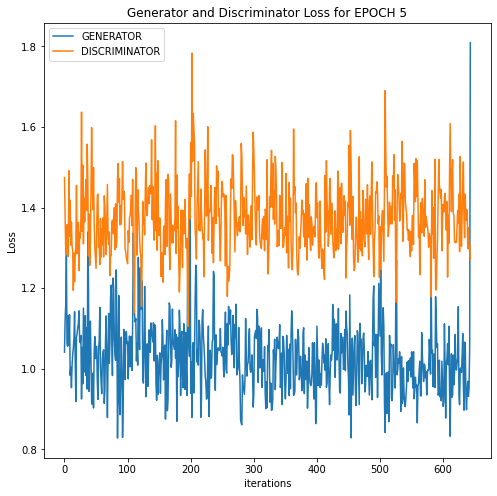

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3932 Generator Loss: 1.0182
Descriminator Loss : 1.1530 Generator Loss: 1.5387


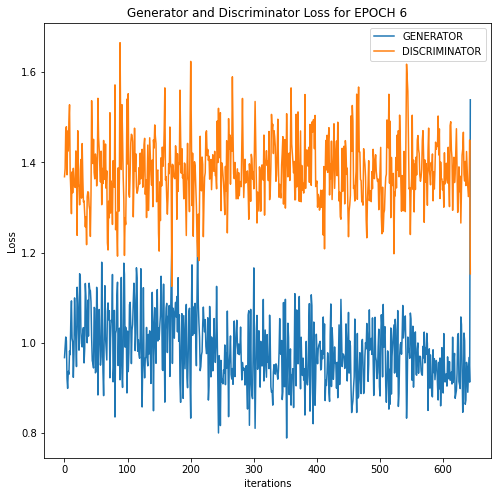

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3981 Generator Loss: 1.0642
Descriminator Loss : 1.1462 Generator Loss: 1.6525


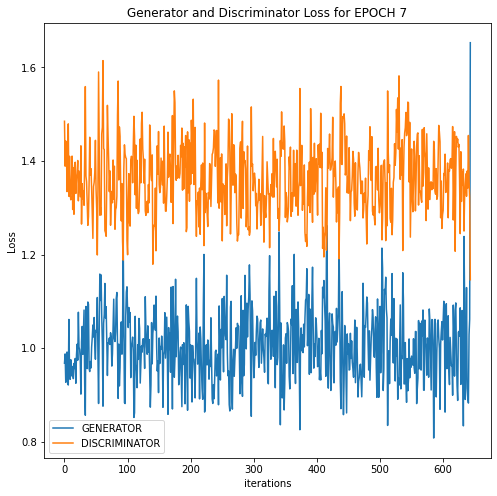

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2359 Generator Loss: 1.1801
Descriminator Loss : 1.5970 Generator Loss: 1.0200


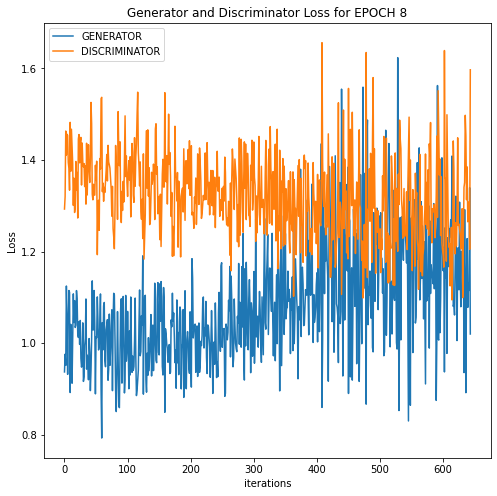

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2732 Generator Loss: 1.2168
Descriminator Loss : 1.5253 Generator Loss: 1.1914


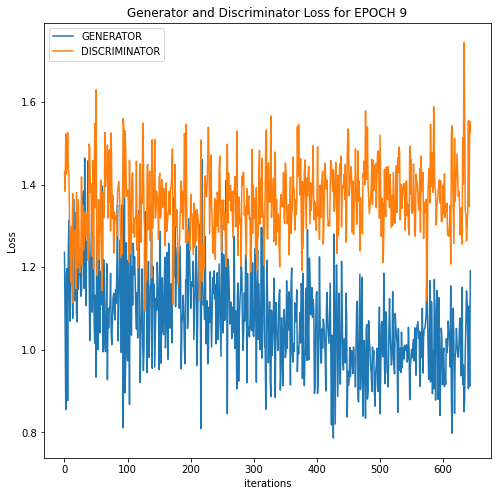

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.4839 Generator Loss: 0.8907
Descriminator Loss : 1.1116 Generator Loss: 1.7527


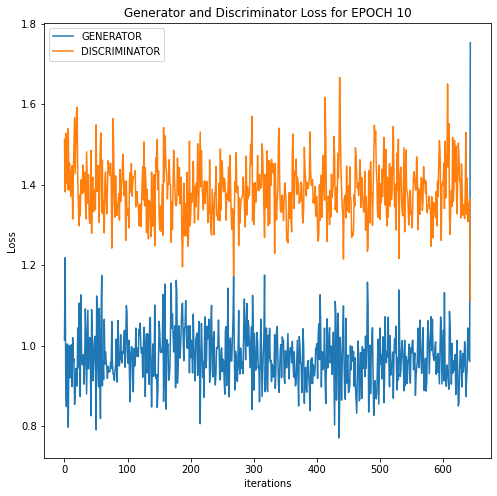

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


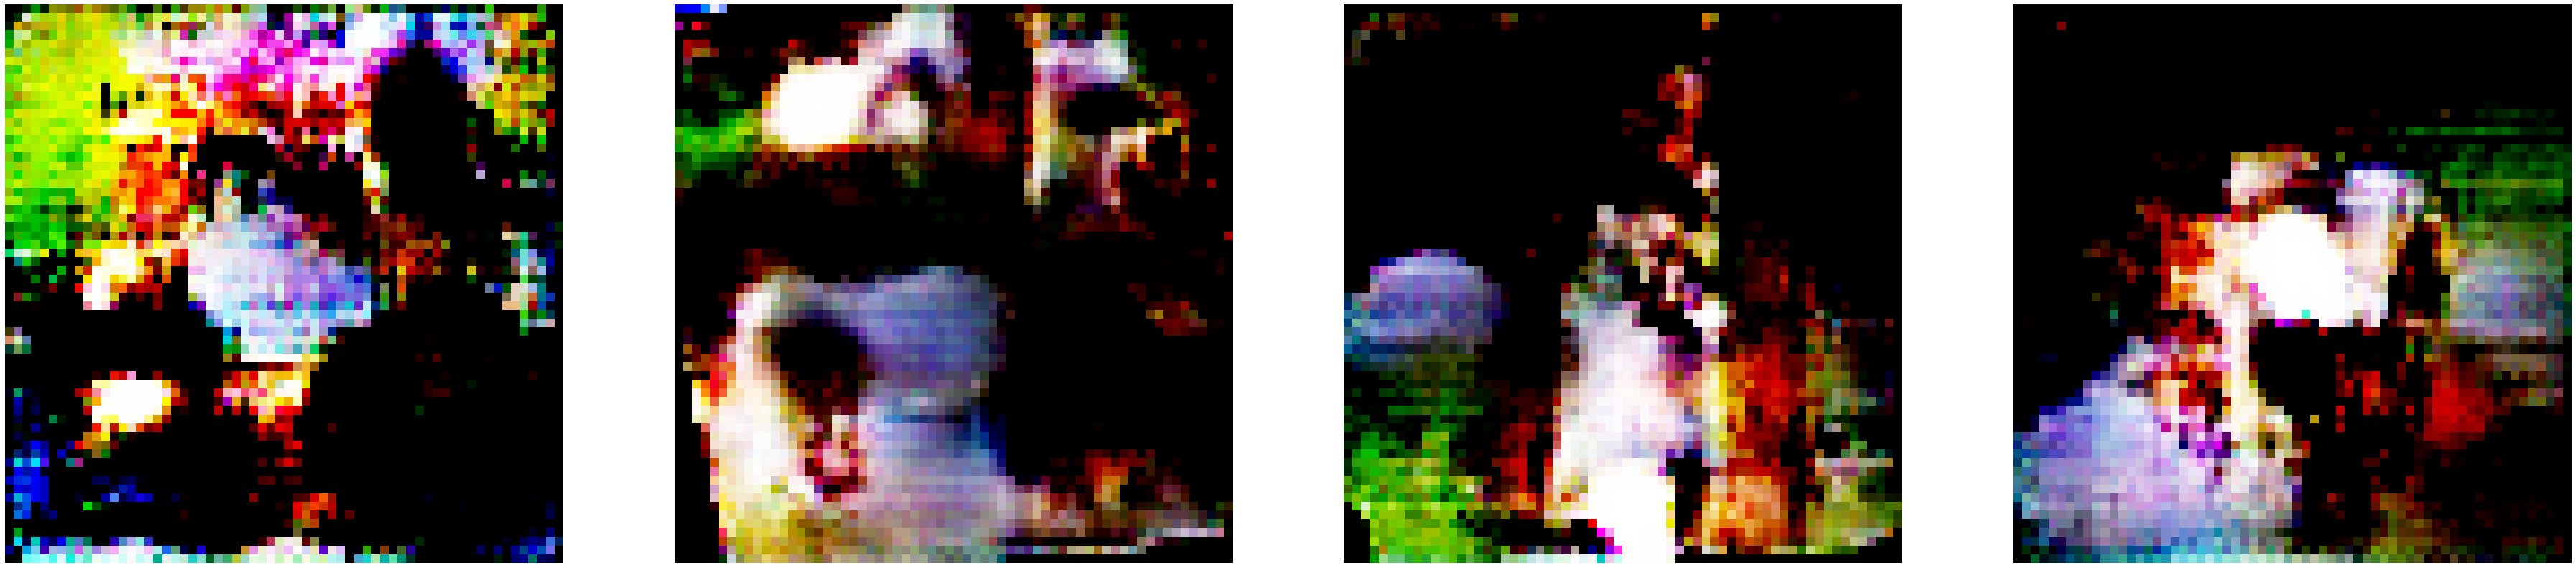

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3827 Generator Loss: 0.9034
Descriminator Loss : 1.2495 Generator Loss: 1.4690


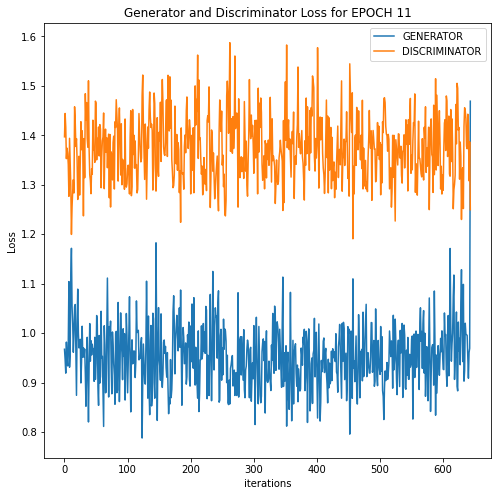

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3763 Generator Loss: 0.9732
Descriminator Loss : 1.4844 Generator Loss: 1.4582


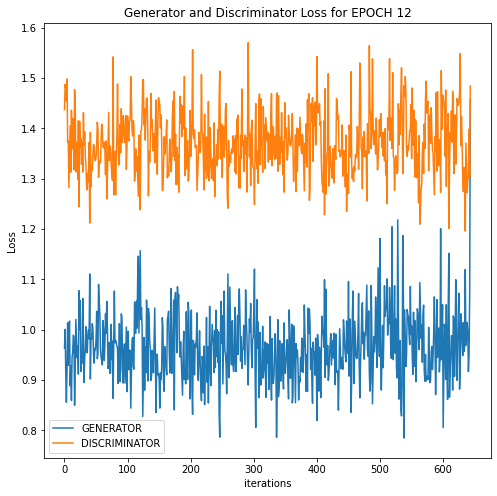

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3811 Generator Loss: 0.9484
Descriminator Loss : 1.0502 Generator Loss: 1.8774


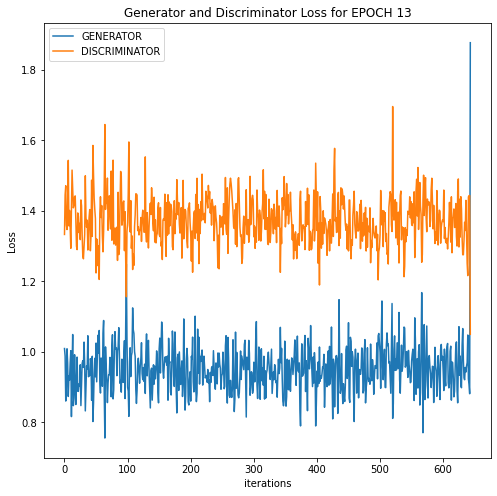

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2965 Generator Loss: 0.9946
Descriminator Loss : 1.5337 Generator Loss: 1.3177


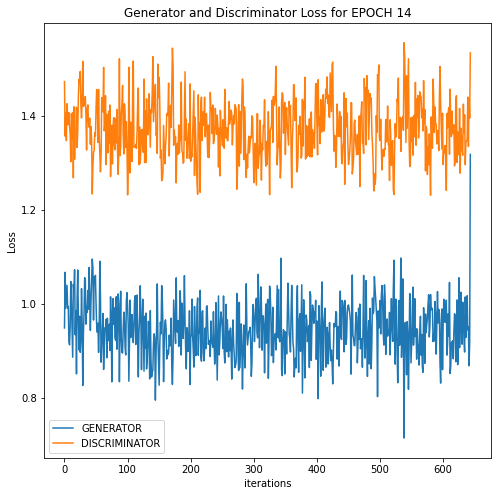

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3887 Generator Loss: 1.0030
Descriminator Loss : 1.3539 Generator Loss: 1.7439


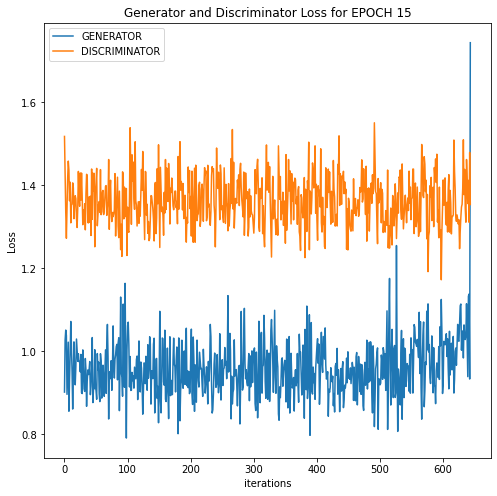

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3048 Generator Loss: 1.0176
Descriminator Loss : 1.5550 Generator Loss: 1.3980


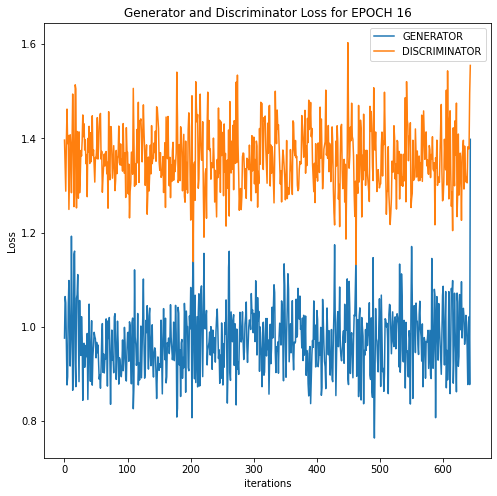

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.4054 Generator Loss: 0.9174
Descriminator Loss : 1.2762 Generator Loss: 1.3603


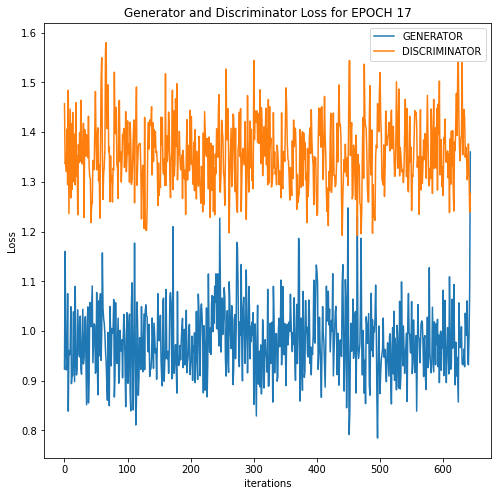

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3046 Generator Loss: 1.0811
Descriminator Loss : 1.2078 Generator Loss: 1.3213


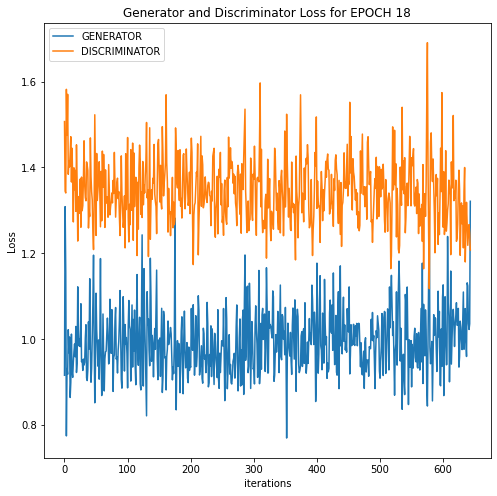

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.3809 Generator Loss: 1.0200
Descriminator Loss : 1.2964 Generator Loss: 2.4541


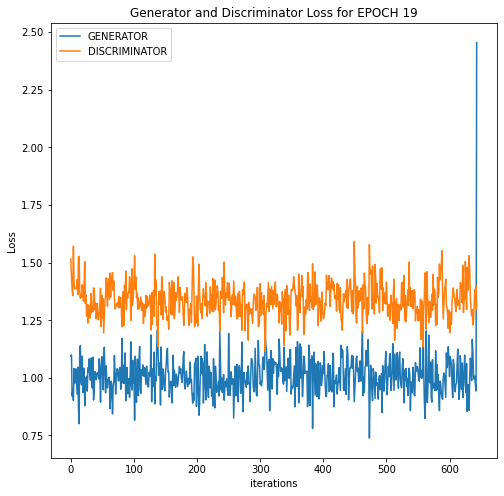

  0%|          | 0/644 [00:00<?, ?it/s]

Descriminator Loss : 1.2867 Generator Loss: 1.0583
Descriminator Loss : 1.3019 Generator Loss: 1.4294


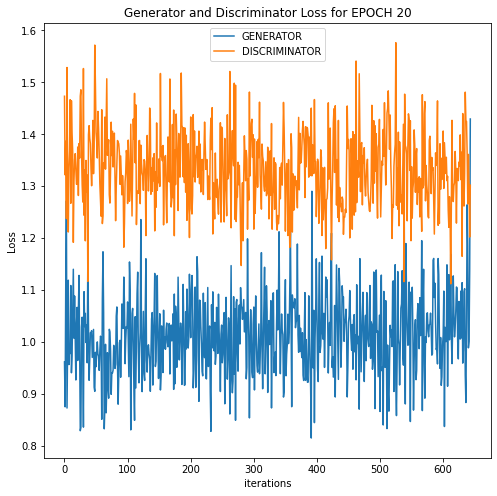

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


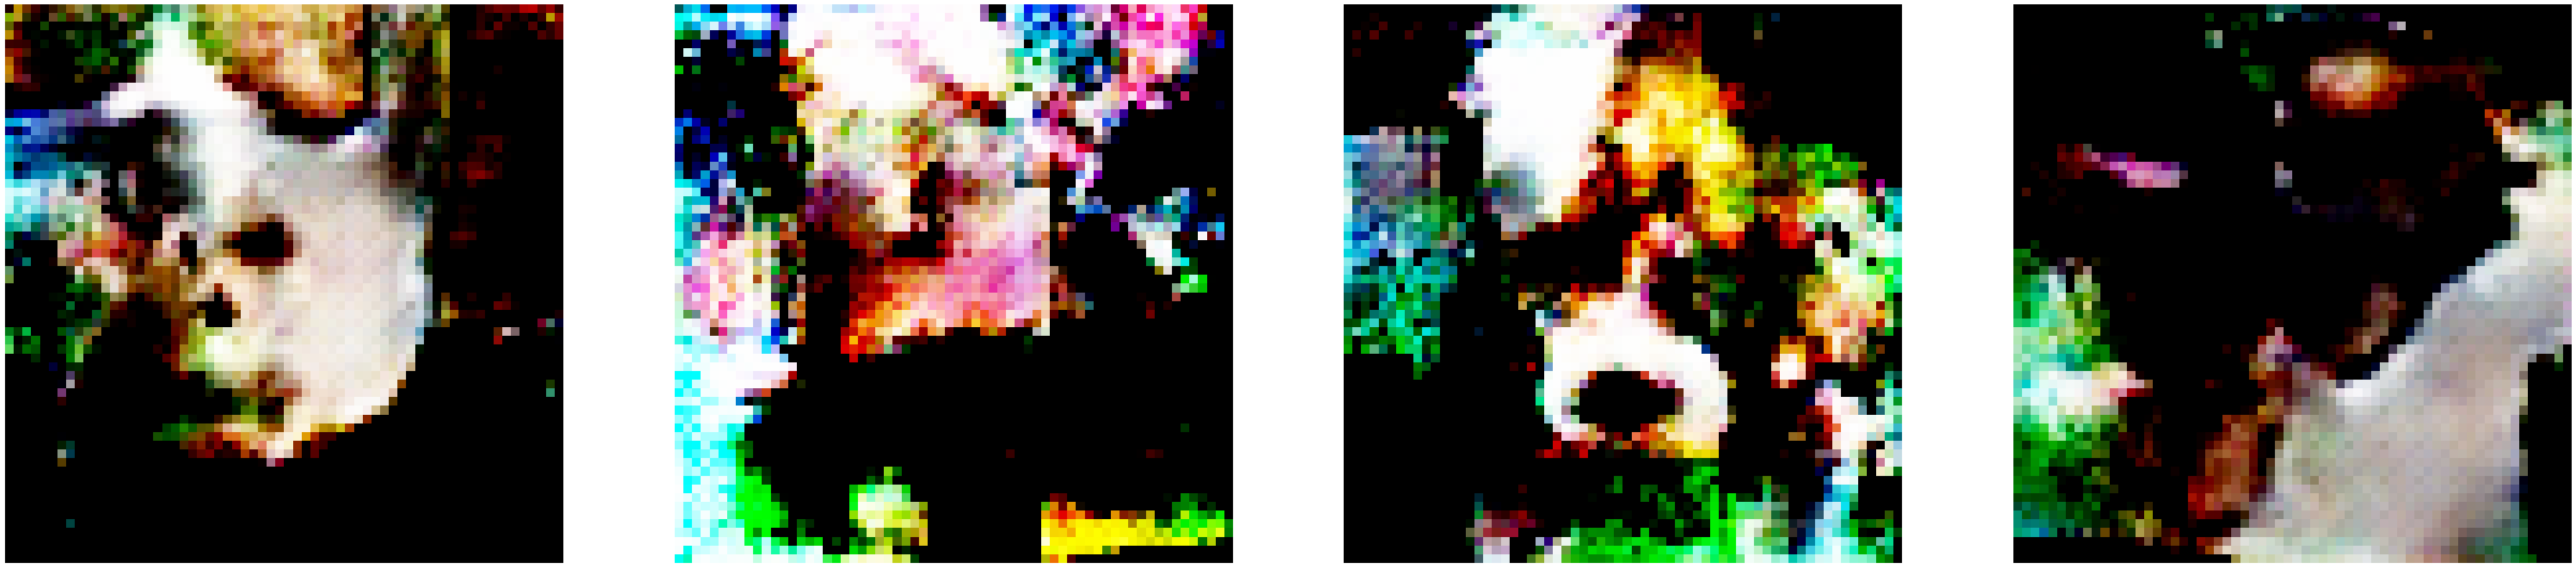

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# def train_gan(curr_epoch, loss_gen, loss_des):
for epoch in range(epochs):
    start = time.time()
    for track, (actual_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):

        discriminator.zero_grad()
        batch_size = actual_images.size(0)
        labels = torch.full((batch_size, 1), real_label)

        output = discriminator(actual_images)
        error_des = loss(output, labels)
        error_des.backward()
        des_output = output.mean().item()

        noise = torch.randn(batch_size, n, 1, 1)
        fake = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake.detach())
        error_des_fake = loss(output, labels)
        error_des_fake.backward()
        des_gen_z1 = output.mean().item()
        total_des_err = error_des + error_des_fake
        optimizer_dis.step()


        generator.zero_grad()
        labels.fill_(real_label)  
        output = discriminator(fake)
        total_gen_err = loss(output, labels)
        total_gen_err.backward()
        des_gen_z2 = output.mean().item()
        optimizer_gen.step()

        loss_gen.append(total_gen_err.item())
        loss_des.append(total_des_err.item())

        if (track+1) % (len(train_loader)//2) == 0:
            print('Descriminator Loss : %.4f Generator Loss: %.4f'
                  % (total_des_err.item(), total_gen_err.item()))

    loss_graph(loss_gen, loss_des, epoch)
    loss_gen = []
    loss_des = []
    if epoch % 10 == 0:
        get_generated_image()

    epoch_time.append(time.time()- start)

In [ ]:
get_generated_image(4)